# Coupling alternative electron pathways with stress response

Nima P. Saadat, Tim Nies, Marvin van Aalst, Brandon Hank, Büsra Demirtas, Oliver Ebenhöh, Anna Matuszyńska

In [1]:
# !pip install -r ../requirements.txt

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it


from scipy.integrate import trapezoid
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator
from assimulo.solvers.sundials import CVodeError
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from modelbase.ode import mca
from matplotlib.colors import TwoSlopeNorm

plt.style.use("./notebook.mplstyle")


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def test_version():
    import modelbase
    from distutils.version import LooseVersion

    if not LooseVersion(modelbase.__version__) >= LooseVersion("1.3.8"):
        raise ImportError("You need modelbase >= 1.3.8 to run this script")


def get_minmax(
    s: Simulator, t_end: float
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    cmin = c.loc[t_end * 0.75 :, :].min()
    cmax = c.loc[t_end * 0.75 :, :].max()
    vmin = v.loc[t_end * 0.75 :, :].min()
    vmax = v.loc[t_end * 0.75 :, :].max()

    return cmin, cmax, vmin, vmax


def get_avg(s: Simulator, t_end: float) -> Tuple[pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    vavg = pd.Series(
        trapezoid(v.loc[t_end * 0.75 :, :], x=v.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=v.columns,
    )

    cavg = pd.Series(
        trapezoid(c.loc[t_end * 0.75 :, :], x=c.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=c.columns,
    )

    return cavg.T, vavg.T


test_version()

In [115]:
%%capture
cd ..

In [116]:
from models import get_model

In [117]:
%%capture
cd analyses-paper/

In [118]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

## Figure 1: Schematic representation

<div style="max-width: 1000px; margin: auto;">

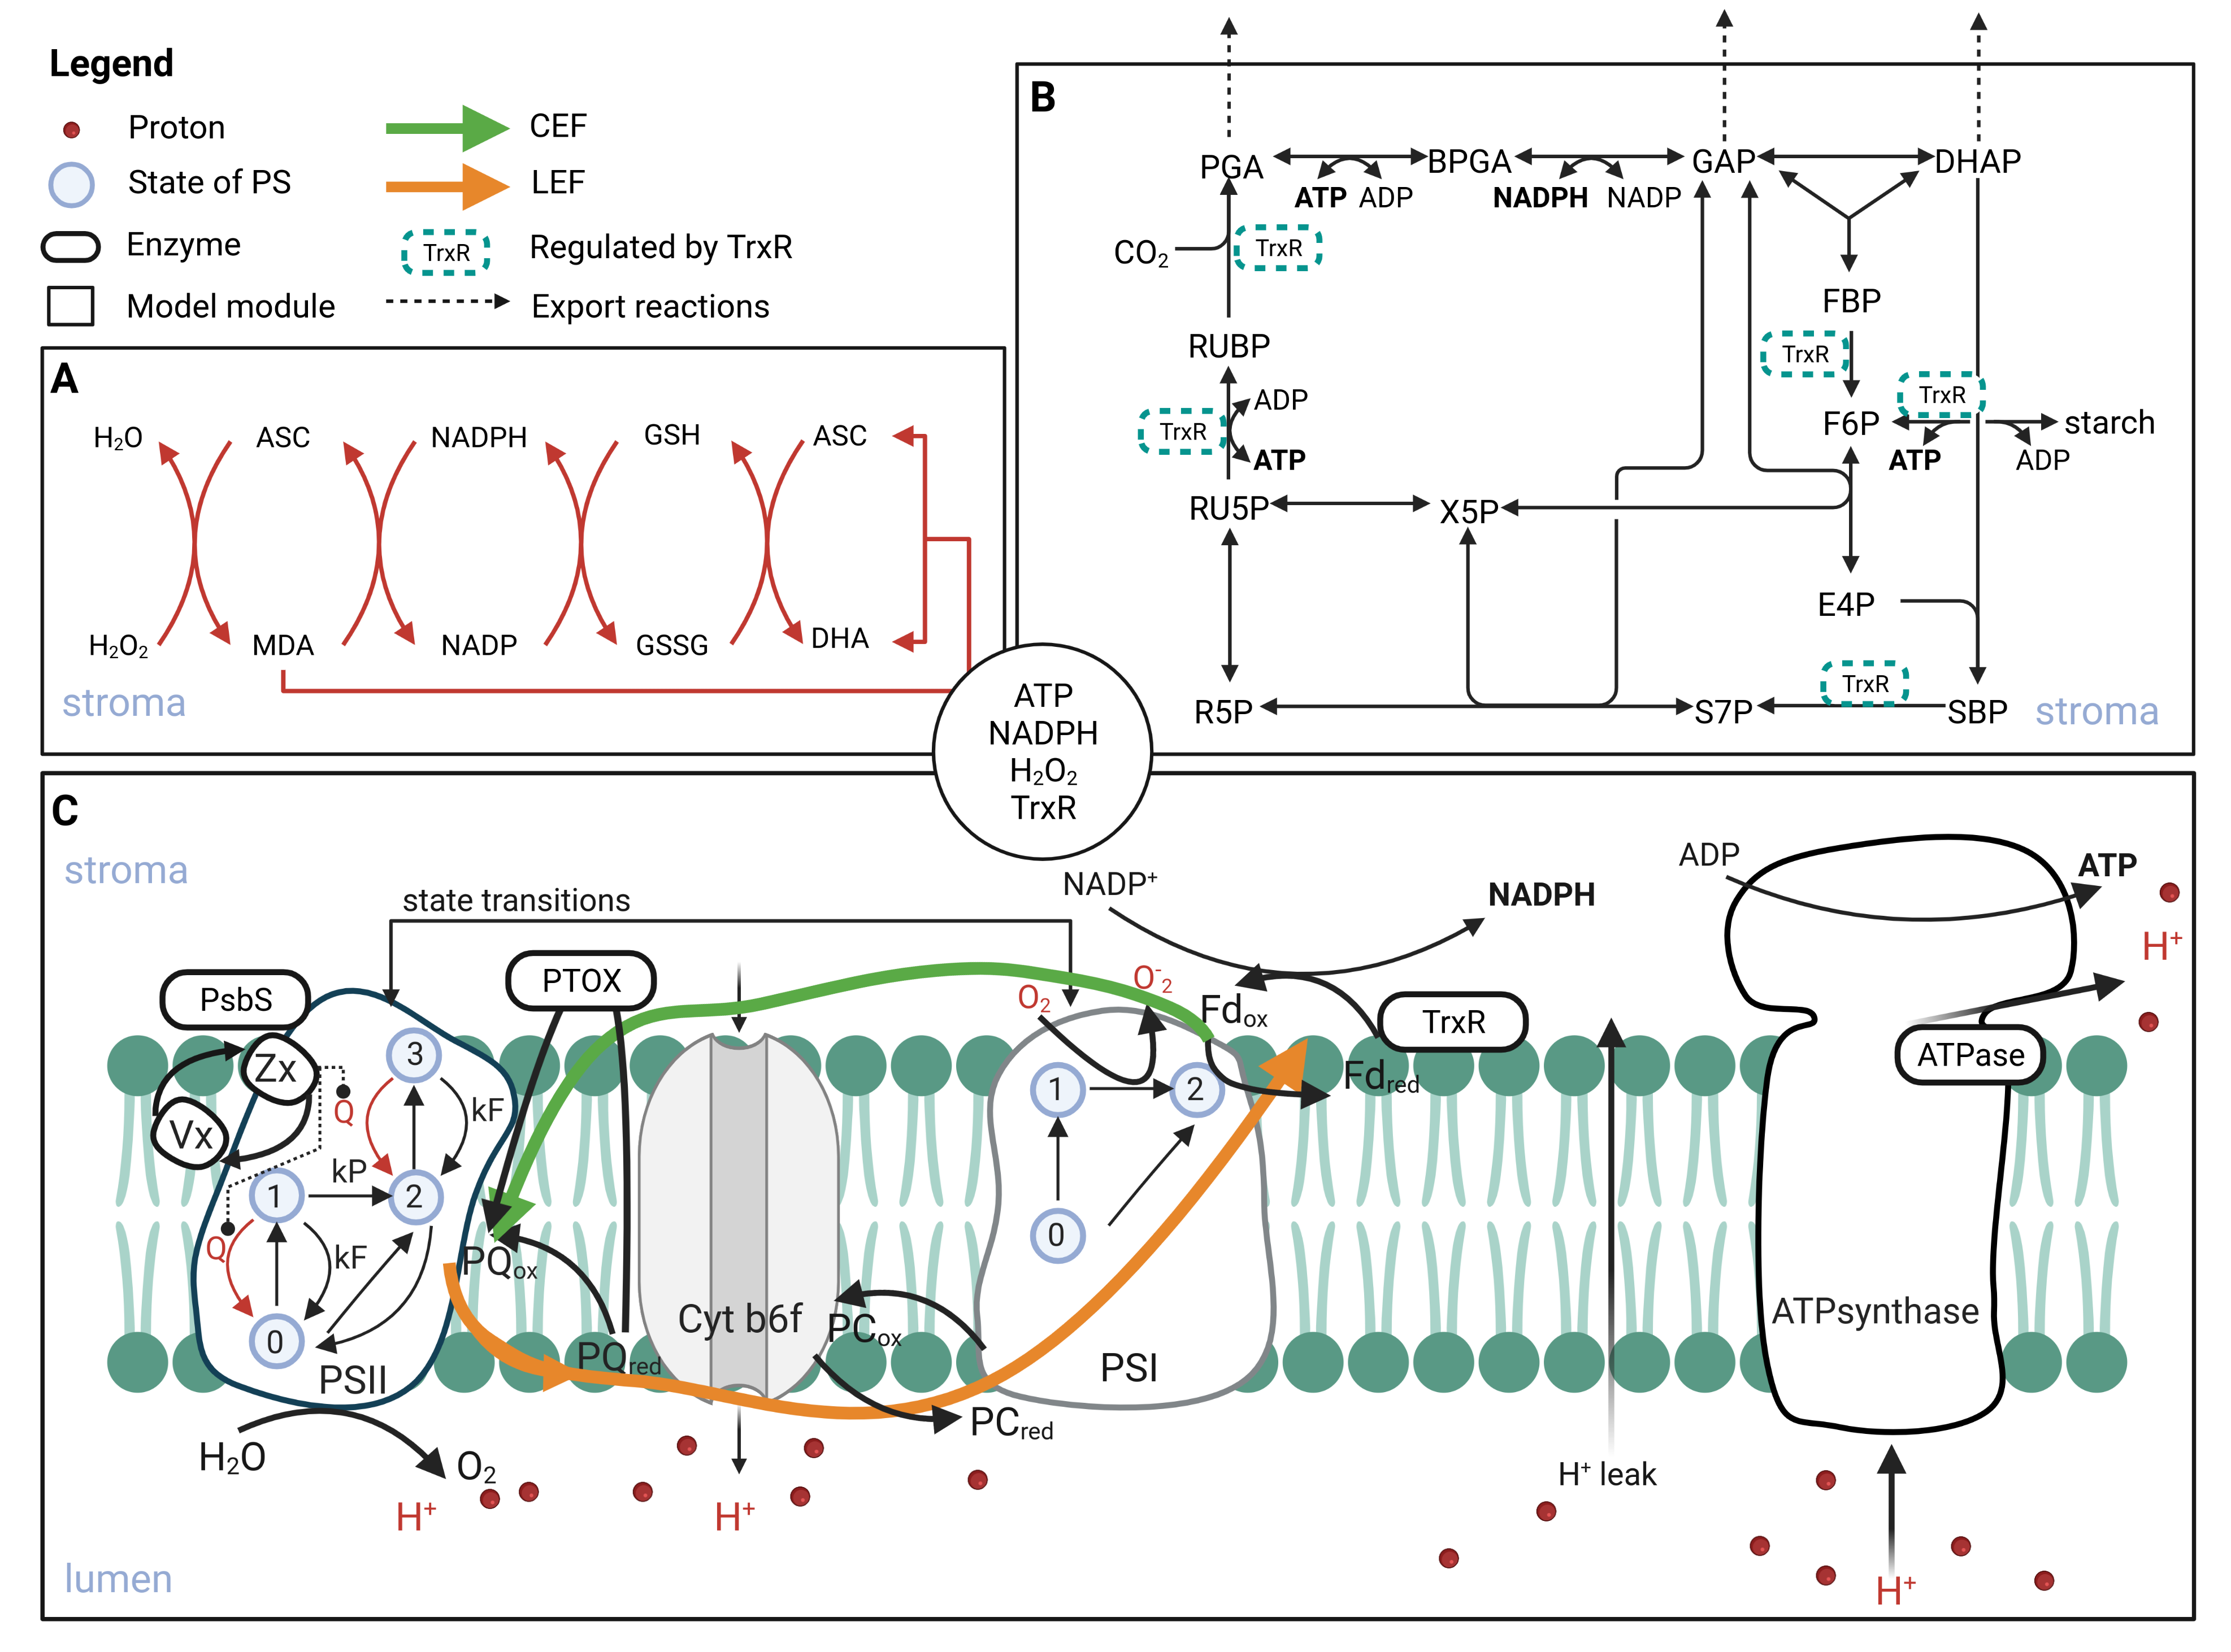

</div>

## Figure 2: Simulated PAM fluorescence trace

In [119]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    t = it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(10)))
    pfds = list(
        [pfd_dark, pfd_pulse] * 0
        + [pfd_illumination, pfd_pulse] * 6
        + [pfd_dark, pfd_pulse] * 0
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    return Fm, NPQ, tm, Fo, to

In [120]:
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc",0)
#s1.update_parameter("gamma0", 0.1)
#s1.update_parameter("gamma1", 0.25)
#s1.update_parameter("gamma2", 0.6)
#s1.update_parameter("gamma3", 0.15)
#s1.update_parameter("kH0", 5e8)
#s1.update_parameter("kPQred", 10)

s1.clear_results()
pam_analysis(
    s1,
    t_relax=10,
    t_pulse=0.8,
    pfd_dark=0,
    pfd_illumination=500,
    pfd_pulse=10000,
)



simulation:   0%|          | 0/12 [00:00<?, ?it/s]

In [121]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

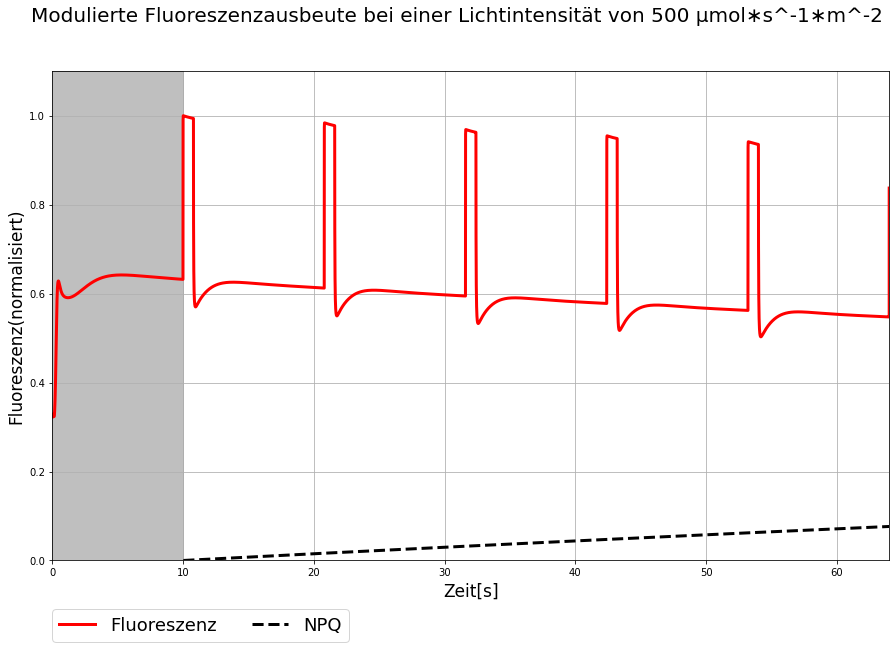

In [156]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(15, 9))

ax.plot(c["Fluo"] / max(c["Fluo"]), color="red", label="Fluoreszenz")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 5, color=(0, 0, 0, 1 / 4))
ax.axvspan(10 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))

ax.set_xlabel("Zeit[s]", fontsize=17)
ax.set_ylabel("Fluoreszenz(normalisiert)", fontsize=17)
ax.set_ylim(0,1.1)
ax.set_xlim(0,64)
fig.suptitle("Modulierte Fluoreszenzausbeute bei einer Lichtintensität von 500 μmol∗s^-1∗m^-2",fontsize=20)
ax.legend(fontsize= 18,bbox_to_anchor=(0,-0.1),ncol=2,loc="upper left")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

In [172]:
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc",1 )
#s1.update_parameter("gamma0", 0.1)
#s1.update_parameter("gamma1", 0.25)
#s1.update_parameter("gamma2", 0.6)
#s1.update_parameter("gamma3", 0.15)
#s1.update_parameter("kH0", 5e8)
s1.update_parameter("kPQred", 1000)

s1.clear_results()
pam_analysis(
    s1,
    t_relax=10,
    t_pulse=0.8,
    pfd_dark=0,
    pfd_illumination=500,
    pfd_pulse=10000,
)

simulation:   0%|          | 0/12 [00:00<?, ?it/s]

In [173]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

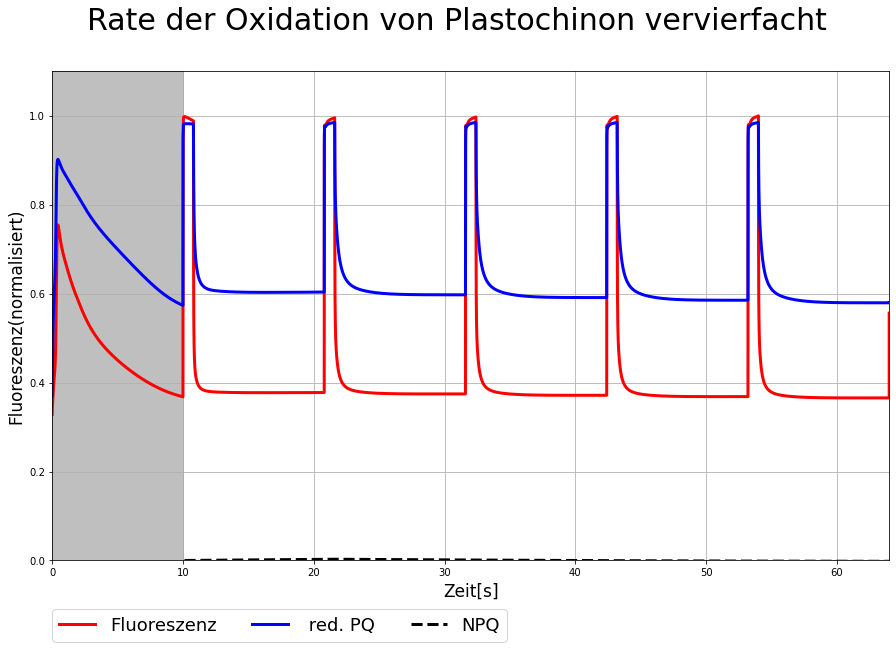

In [174]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red", label="Fluoreszenz")
ax.plot(c["PQred"] /s1.model.get_parameter("PQtot"), color="blue",label= " red. PQ")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 5, color=(0, 0, 0, 1 / 4))
ax.axvspan(10 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
fig.suptitle("Rate der Oxidation von Plastochinon vervierfacht",fontsize=30)
ax.set_xlabel("Zeit[s]", fontsize=17)
ax.set_ylabel("Fluoreszenz(normalisiert)", fontsize=17)
ax.set_ylim(0,1.1)
ax.set_xlim(0,64)

ax.legend(fontsize= 18,bbox_to_anchor=(0,-0.1),ncol=3,loc="upper left")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

In [162]:
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc",1 )
#s1.update_parameter("gamma0", 0.1)
#s1.update_parameter("gamma1", 0.25)
#s1.update_parameter("gamma2", 0.6)
#s1.update_parameter("gamma3", 0.15)
#s1.update_parameter("kH0", 5e8)
s1.update_parameter("kPQred", 10)

s1.clear_results()
pam_analysis(
    s1,
    t_relax=10,
    t_pulse=0.8,
    pfd_dark=0,
    pfd_illumination=500,
    pfd_pulse=10000,
)


simulation:   0%|          | 0/12 [00:00<?, ?it/s]

In [163]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

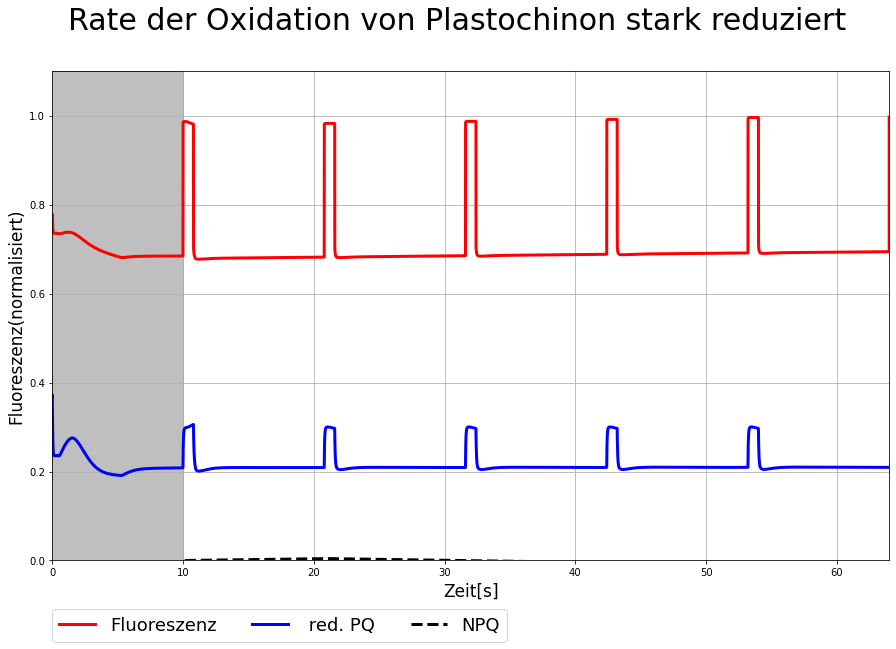

In [164]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red", label="Fluoreszenz")
ax.plot(c["PQred"] /s1.model.get_parameter("PQtot"), color="blue",label= " red. PQ")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 5, color=(0, 0, 0, 1 / 4))
ax.axvspan(10 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
fig.suptitle("Rate der Oxidation von Plastochinon stark reduziert",fontsize=30)
ax.set_xlabel("Zeit[s]", fontsize=17)
ax.set_ylabel("Fluoreszenz(normalisiert)", fontsize=17)
ax.set_ylim(0,1.1)
ax.set_xlim(0,64)

ax.legend(fontsize= 18,bbox_to_anchor=(0,-0.1),ncol=3,loc="upper left")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

In [165]:
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 1)
s1.update_parameter("gamma0", 0)
s1.update_parameter("gamma1", 0)
s1.update_parameter("gamma2", 0)
s1.update_parameter("gamma3", 0)
s1.update_parameter("kH0", 0)
#s1.update_parameter("kPQred", 250)
s1.clear_results()
pam_analysis(
    s1,
    t_relax=10,
    t_pulse=0.8,
    pfd_dark=0,
    pfd_illumination=150,
    pfd_pulse=10000,
)


simulation:   0%|          | 0/12 [00:00<?, ?it/s]

In [166]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

In [168]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red", label="Fluoreszenz")
ax.plot(c["Q"]/s1.model.get_parameter("PSIItot"), color="blue", label="Quencher")
#ax.plot(c["Q"], color="blue", label="Quencher")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 5, color=(0, 0, 0, 1 / 4))
ax.axvspan(10 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set_xlabel("Zeit[s]", fontsize=17)
ax.set_ylabel("Fluoreszenz(normalisiert)", fontsize=17)
ax.set_ylim(0,1.1)
ax.set_xlim(0,64)
fig.suptitle("Ausschaltung der Löschung bei 150 μmol∗s^-1∗m^-2",fontsize=30)
ax.legend(fontsize= 18,bbox_to_anchor=(0,-0.1),ncol=3,loc="upper left")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

In [169]:
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 1)
s1.update_parameter("gamma0", 0.1)
s1.update_parameter("gamma1", 0.25)
s1.update_parameter("gamma2", 0.6)
s1.update_parameter("gamma3", 0.15)
s1.update_parameter("kH0", 5e8)
s1.update_parameter("kPQred", 250)
s1.clear_results()
pam_analysis(
    s1,
    t_relax=10,
    t_pulse=0.8,
    pfd_dark=0,
    pfd_illumination=150,
    pfd_pulse=10000,
)

simulation:   0%|          | 0/12 [00:00<?, ?it/s]

In [170]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

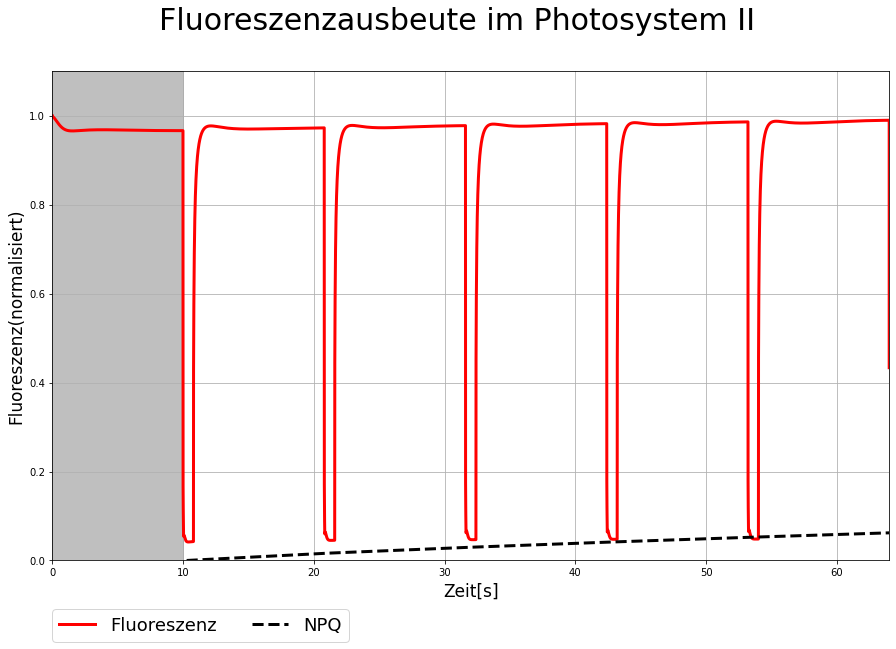

In [171]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(c["B0"]/max(c["B0"]), color="red" ,label = "Fluoreszenz")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 5, color=(0, 0, 0, 1 / 4))
ax.axvspan(10 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set_xlabel("Zeit[s]", fontsize=17)
ax.set_ylabel("Fluoreszenz(normalisiert)", fontsize=17)
ax.set_ylim(0,1.1)
ax.set_xlim(0,64)
fig.suptitle("Fluoreszenzausbeute im Photosystem II",fontsize=30)
ax.legend(fontsize= 18,bbox_to_anchor=(0,-0.1),ncol=3,loc="upper left")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()